In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
hdb_transport = pd.read_csv('./hdb_ll_mrt_cp.csv',index_col=0)

In [3]:
hdb_transport.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,HERE_address,Latitude,Longitude,closest_mrt,dist_mrt_km,closest_cp,dist_cp_km
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.8374,YIO CHU KANG MRT STATION SINGAPORE,1.0909,BLK 173/176 ANG MO KIO AVE 4,0.1152
1,2015-12,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,69,275000.0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.8374,YIO CHU KANG MRT STATION SINGAPORE,1.0909,BLK 173/176 ANG MO KIO AVE 4,0.1152
2,2016-05,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,68,310000.0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.8374,YIO CHU KANG MRT STATION SINGAPORE,1.0909,BLK 173/176 ANG MO KIO AVE 4,0.1152
3,2016-06,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,68,253000.0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.8374,YIO CHU KANG MRT STATION SINGAPORE,1.0909,BLK 173/176 ANG MO KIO AVE 4,0.1152
4,2016-11,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,68,290000.0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.8374,YIO CHU KANG MRT STATION SINGAPORE,1.0909,BLK 173/176 ANG MO KIO AVE 4,0.1152


In [4]:
amentities = pd.read_csv('./unique_amenities_counts.csv',index_col=0)

In [5]:
amentities.head()

,HERE_address,Latitude,Longitude,schs_1km,schs_2km,sap_sch_1km,sap_sch_2km,autonomous_sch_1km,autonomous_sch_2km,gifted_sch_1km,gifted_sch_2km,ip_sch_1km,ip_sch_2km,hawker_1km,hawker_2km,supermarket_1km,supermarket_2km
0,174 ANG MO KIO AVE 4 Singapore,1.37541,103.83740,6,14,1,2,1,2,0,0,1,1,5,8,4,10
13,541 ANG MO KIO AVE 10 Singapore,1.37412,103.85576,3,11,0,0,1,1,0,0,0,0,2,10,4,15
24,163 ANG MO KIO AVE 4 Singapore,1.37387,103.83834,6,14,1,2,1,2,0,0,1,1,5,8,5,12
33,446 ANG MO KIO AVE 10 Singapore,1.36794,103.85543,5,14,0,1,1,2,0,1,0,1,4,10,5,15
35,557 ANG MO KIO AVE 10 Singapore,1.37145,103.85785,3,12,0,0,1,1,0,1,0,0,2,7,4,14


In [6]:
#Merge the amenities information
hdb_amenities = hdb_transport.merge(amentities.drop(['Latitude','Longitude'],axis=1), how='inner', on='HERE_address')

In [7]:
#Check the columns
hdb_amenities.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'HERE_address', 'Latitude',
       'Longitude', 'closest_mrt', 'dist_mrt_km', 'closest_cp', 'dist_cp_km',
       'schs_1km', 'schs_2km', 'sap_sch_1km', 'sap_sch_2km',
       'autonomous_sch_1km', 'autonomous_sch_2km', 'gifted_sch_1km',
       'gifted_sch_2km', 'ip_sch_1km', 'ip_sch_2km', 'hawker_1km',
       'hawker_2km', 'supermarket_1km', 'supermarket_2km'],
      dtype='object')

In [8]:
#One-hot encode categorical features
dummies = pd.get_dummies(hdb_amenities[['town','storey_range','flat_model','closest_mrt']])

In [9]:
#Remove the original categorical columns
hdb_amenities.drop(['town','storey_range','flat_model'],axis=1,inplace=True)

In [10]:
#Concatenate the one-hot-encoded features
hdb_amenities_dummies = pd.concat([hdb_amenities,dummies],axis=1)

In [11]:
#choose Flat features, mrt features, schols within 2km, other amenities within 1km
chosen_df = hdb_amenities_dummies.drop(['block','street_name','lease_commence_date','flat_type','HERE_address',
                                        'closest_mrt','closest_cp','dist_cp_km','Latitude','Longitude',
                                        'schs_1km','sap_sch_1km','autonomous_sch_1km','gifted_sch_1km','ip_sch_1km',
                                        'hawker_2km','supermarket_2km'],axis=1).copy()

## Modelling 

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score,cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [13]:
#Split the data for train and test 
tree_train = chosen_df[~chosen_df['month'].str.contains('2018')].drop(['resale_price','month'],axis=1).copy()
y_train = chosen_df[~chosen_df['month'].str.contains('2018')]['resale_price'].copy()
tree_test = chosen_df[chosen_df['month'].str.contains('2018')].drop(['resale_price','month'],axis=1).copy()
y_test = chosen_df[chosen_df['month'].str.contains('2018')]['resale_price'].copy()

In [14]:
tree_train.columns.to_list()

['floor_area_sqm',
 'remaining_lease',
 'dist_mrt_km',
 'schs_2km',
 'sap_sch_2km',
 'autonomous_sch_2km',
 'gifted_sch_2km',
 'ip_sch_2km',
 'hawker_1km',
 'supermarket_1km',
 'town_ANG MO KIO',
 'town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'storey_range_01 TO 03',
 'storey_range_04 TO 06',
 'storey_range_07 TO 09',
 'storey_range_10 TO 12',
 'storey_range_13 TO 15',
 'storey_range_16 TO 18',
 'storey_range_19 TO 21',
 'storey_range_22 TO 24',
 'storey_range_25 TO 27',
 'storey_range_28 TO 30',
 'storey_range_31 TO 33',
 'storey_range_34 TO 36',
 'st

In [15]:
def model_scores_cv(estimator,X,y):
    """
    This function takes a model with the independent and target variables and returns a list of 
    the cross validated mean r2 score and standard deviation as well as the mean RMSE and standard deviation.
    """
    scores = cross_validate(estimator,X,y,n_jobs=-1,cv=10,scoring =['r2','neg_mean_squared_error'])
    
    mean_r2_score = round(scores['test_r2'].mean(),4)
    std_r2 = round(scores['test_r2'].std(),4)
    
    print("Mean r2 score: ", mean_r2_score, '±', std_r2)
    
    mean_rmse_score = round(np.sqrt(scores['test_neg_mean_squared_error']*(-1)).mean(),4)
    rmse_std = round(np.sqrt(scores['test_neg_mean_squared_error']*(-1)).std(),4)
    
    print("Mean RMSE score: ", mean_rmse_score, '±', rmse_std)
    
    return [mean_r2_score, std_r2, mean_rmse_score, rmse_std]

In [16]:
comparison_df = pd.DataFrame({'model_name':[],'train_r2_mean':[],'train_r2_std':[],'train_RMSE_mean':[],'train_RMSE_std':[]})
def add_model_train(name,results_list):
    """
    This function takes in a name and a list of scores for summary comparison (training set)
    """
    global comparison_df
    comparison_df = comparison_df.append(pd.Series(([name]+results_list),
                               index=['model_name','train_r2_mean','train_r2_std','train_RMSE_mean','train_RMSE_std']),
                     ignore_index=True)
    return comparison_df

In [17]:
def model_test_scores(model,X_trn,y_trn,X_tst,y_tst,cols):
    """
    This function takes a model, the train and test variables and targets as well as the variable column names,
    returning the dataframe of variables and their coefficients, the r2, RMSE and predicted values
    """
    final_model = model.fit(X_trn,y_trn)
    
    predictions = model.predict(X_tst)
    
    score = r2_score(y_tst,predictions)
    rmse = round(np.sqrt(mean_squared_error(y_tst,predictions)),2)
    
    #Print the results
    print('Test r2 score: ', score)
    print('Test Mean Squared Error: ', rmse)
    
    coef_summary = pd.DataFrame({'Features':cols,'coef':model.coef_,'abs coef':abs(model.coef_)})
    
    return coef_summary, score, rmse, predictions

In [18]:
comparison_test = pd.DataFrame({'model_name':[],'test_r2_mean':[],'test_RMSE_mean':[]})
def add_model_test(name,r2,RMSE):
    """
    This function takes in a name and a list of scores for summary comparison (test set)
    """
    global comparison_test
    comparison_test = comparison_test.append(pd.Series([name,r2,RMSE],
                               index=['model_name','test_r2_mean','test_RMSE_mean']),
                     ignore_index=True)
    return comparison_test

In [19]:
def pred_real_plots_res(y_true,y_pred,model_name):
    '''
    This function takes in the true target values, predicted target values and model name to plot 
    the predicted versus real target values as well as the distribution of residuals
    '''
    plt.figure(figsize = (12,6))
    
    plt.subplot(1,2,1)
    plt.scatter(x=y_true/1000,y=y_pred/1000,c='blue',alpha=0.3,edgecolors='k')
    plt.plot((min(np.append(y_true,y_pred))/1000,max(np.append(y_true,y_pred))/1000),
            ((min(np.append(y_true,y_pred))/1000,max(np.append(y_true,y_pred))/1000)),c='k')
    
    plt.xlim=plt.ylim
    plt.title('{} Model \nPredicted resale price against actual resale price'.format(model_name),fontsize=13)
    plt.xlabel('Actual Price (in thousands)',fontsize=13)
    plt.ylabel('Predicted Price (in thousands)',fontsize=13)
    
    plt.subplot(1,2,2)
    plt.hist((y_true-y_pred)/1000,bins=100,edgecolor='k',color='blue')
    
    plt.title('{} Model \nDistribution of Residuals'.format(model_name),fontsize=13)
    plt.xlabel('Residuals (in thousands)',fontsize=13)
    plt.ylabel('Count',fontsize=13)
    plt.grid()

## Random Forest 

In [20]:
rfr_tree = RandomForestRegressor(n_estimators=100, random_state=42)

In [21]:
#Run cross validation on training set
rfr_tree_scores = model_scores_cv(rfr_tree,tree_train,y_train)

Mean r2 score:  0.9429 ± 0.0217
Mean RMSE score:  32869.8951 ± 8135.6948


In [22]:
rfr_tree.fit(tree_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
#Retrieve predictions and scores
rfr_tree_predictions = rfr_tree.predict(tree_test)
rfr_tree_score = round(r2_score(y_test,rfr_tree_predictions),4)
rfr_tree_rmse = round(np.sqrt(mean_squared_error(y_test,rfr_tree_predictions)),2)

print('Test r2 score: ',rfr_tree_score)
print('Test RMSE: ',rfr_tree_rmse)

Test r2 score:  0.9528
Test RMSE:  34234.22


In [24]:
#Take a look at MAE
mean_absolute_error(y_test,rfr_tree_predictions)

24867.73099793689

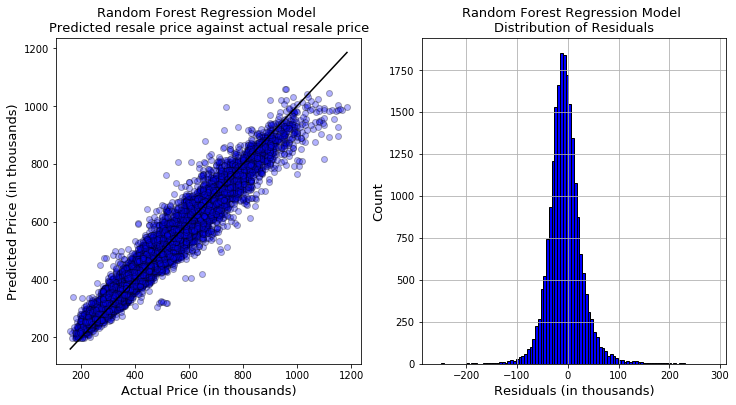

In [25]:
#Check predictions and residuals
pred_real_plots_res(y_test,rfr_tree_predictions,'Random Forest Regression')

In [26]:
from rfpimp import *

In [27]:
#Take a look at the 10 most impactful features
rfr_tree_df = pd.DataFrame({'Features':tree_train.columns,'Importance':rfr_tree.feature_importances_})
rfr_tree_df.sort_values('Importance', ascending=False).head(10)

,Features,Importance
0,floor_area_sqm,0.490258
8,hawker_1km,0.142594
1,remaining_lease,0.052070
6,gifted_sch_2km,0.051047
64,flat_model_New Generation,0.047459
2,dist_mrt_km,0.039428
56,flat_model_DBSS,0.026882
3,schs_2km,0.017086
4,sap_sch_2km,0.009862
7,ip_sch_2km,0.009565


In [28]:
#Take a look at the 10 most impactful features (permutated importance)
results = importances(rfr_tree, tree_test, y_test, n_samples=-1)
sorted_results_df = results.sort_values('Importance',ascending=False).head(10)
sorted_results_df

,Importance
Feature,
floor_area_sqm,1.035499
hawker_1km,0.387832
remaining_lease,0.148456
dist_mrt_km,0.081726
gifted_sch_2km,0.080231
flat_model_DBSS,0.044119
flat_model_New Generation,0.038084
town_BUKIT MERAH,0.032121
sap_sch_2km,0.024582


In [29]:
sorted_results_df=sorted_results_df.sort_values('Importance')

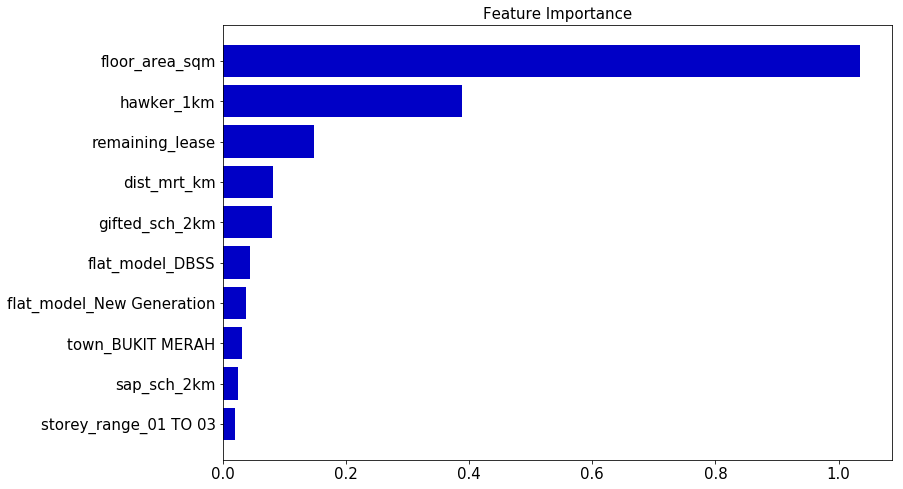

In [30]:
#Plot the 10 most impactful features
plt.figure(figsize=(12,8))
plt.barh(y=sorted_results_df.index,width=sorted_results_df['Importance'],color='#0000c6')

plt.title("Feature Importance", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
#Add to the training scores table for comparison
add_model_train('Random Forest (all cols)',rfr_tree_scores)

,model_name,train_r2_mean,train_r2_std,train_RMSE_mean,train_RMSE_std
0,Random Forest (all cols),0.9429,0.0217,32869.8951,8135.6948


In [32]:
#Add results to the test scores table for comparison
add_model_test('Random Forest (all cols)',rfr_tree_score, rfr_tree_rmse)

,model_name,test_r2_mean,test_RMSE_mean
0,Random Forest (all cols),0.9528,34234.22


## XGBoost

In [34]:
xgr = XGBRegressor()

In [35]:
#Retrieve cross validated training scores
xgr_scores = model_scores_cv(xgr,tree_train,y_train)

Mean r2 score:  0.8946 ± 0.0131
Mean RMSE score:  44863.3242 ± 4733.7445


In [36]:
add_model_train('XGBoost (default)',xgr_scores)

,model_name,train_r2_mean,train_r2_std,train_RMSE_mean,train_RMSE_std
0,Random Forest (all cols),0.9429,0.0217,32869.8951,8135.6948
1,XGBoost (default),0.8946,0.0131,44863.3242,4733.7445


In [37]:
#Retrieve predictions and test scores
xgr.fit(tree_train,y_train)
xgr_predictions = xgr.predict(tree_test)
xgr_score = round(r2_score(y_test,xgr_predictions),4)
xgr_rmse = round(np.sqrt(mean_squared_error(y_test,xgr_predictions)),2)

print('Test r2 score: ',xgr_score)
print('Test RMSE: ',xgr_rmse)

Test r2 score:  0.8863
Test RMSE:  53112.08


In [38]:
#Add results to the test scores table for comparison
add_model_test('XGBoost (default)',xgr_score, xgr_rmse)

,model_name,test_r2_mean,test_RMSE_mean
0,Random Forest (all cols),0.9528,34234.22
1,XGBoost (default),0.8863,53112.08


## Tuned XGBoost

In [39]:
#Create search hyperparameters
xgr_params ={
    "n_estimators":[100,150,200],
    'max_depth':[7,9,11,13,15,17,19,21],
    'learning_rate':[0.025,0.05,0.1,0.15],
    'n_jobs':[-1],
    'random_state':[42]
}

xgr_search = GridSearchCV(xgr,param_grid=xgr_params,cv=5,n_jobs=-1,verbose=1,scoring='neg_mean_squared_error')

In [40]:
xgr_tune = xgr_search.fit(tree_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 172.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 197.2min finished


In [41]:
#Check the score
np.sqrt(xgr_tune.best_score_*-1)

31943.59878592901

In [42]:
#Check the tuned hyperparameters
xgr_tune.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
#Retrieve cross validated training scores
xgr_tune_scores = model_scores_cv(xgr_tune.best_estimator_,tree_train,y_train)

Mean r2 score:  0.9524 ± 0.0126
Mean RMSE score:  30063.855 ± 5583.9879


In [44]:
#Add to the training scores table for comparison
add_model_train('Tuned XGB',xgr_tune_scores)

,model_name,train_r2_mean,train_r2_std,train_RMSE_mean,train_RMSE_std
0,Random Forest (all cols),0.9429,0.0217,32869.8951,8135.6948
1,XGBoost (default),0.8946,0.0131,44863.3242,4733.7445
2,Tuned XGB,0.9524,0.0126,30063.8550,5583.9879


In [45]:
def xgr_score(model,x_train,y_train,x_test,y_test): 
    '''
    This function takes in a model, training varaibles and target, test variables and target
    and returns the r2 and RMSE scores
    '''
    model.fit(x_train,y_train)
    model_predictions = model.predict(x_test)
    model_score = round(r2_score(y_test,model_predictions),4)
    model_rmse = round(np.sqrt(mean_squared_error(y_test,model_predictions)),2)

    print('Test r2 score: ',model_score)
    print('Test RMSE: ', model_rmse)
    
    return model_score, model_rmse

In [46]:
#Retrieve test scores
xgr_tune_score, xgr_tune_rmse = xgr_score(xgr_tune.best_estimator_,tree_train,y_train,tree_test,y_test)

Test r2 score:  0.9534
Test RMSE:  34006.7


In [47]:
#Add results to the test scores table for comparison
add_model_test('Tuned XGB',xgr_tune_score, xgr_tune_rmse)

,model_name,test_r2_mean,test_RMSE_mean
0,Random Forest (all cols),0.9528,34234.22
1,XGBoost (default),0.8863,53112.08
2,Tuned XGB,0.9534,34006.70


In [48]:
tuned_xgb = xgr_tune.best_estimator_

In [49]:
#Retrieve the predicted values
tuned_xgb.fit(tree_train,y_train)
xgr_tune_predictions = tuned_xgb.predict(tree_test)

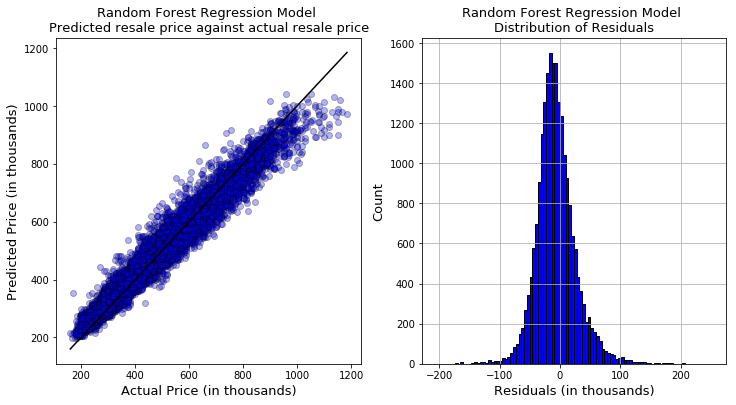

In [50]:
#Check predictions and residuals
pred_real_plots_res(y_test,xgr_tune_predictions,'Random Forest Regression')

In [51]:
tuned_xgb_df = pd.DataFrame({'Features':tree_train.columns,'Importance':tuned_xgb.feature_importances_})

In [52]:
#Take a look at the 10 most impactful features
tuned_xgb_top10 = tuned_xgb_df.sort_values('Importance', ascending=False).head(10)
tuned_xgb_top10

,Features,Importance
0,floor_area_sqm,0.229857
2,dist_mrt_km,0.171557
1,remaining_lease,0.164427
3,schs_2km,0.045050
9,supermarket_1km,0.036406
36,storey_range_01 TO 03,0.031358
37,storey_range_04 TO 06,0.025617
8,hawker_1km,0.025175
38,storey_range_07 TO 09,0.019181
39,storey_range_10 TO 12,0.016910


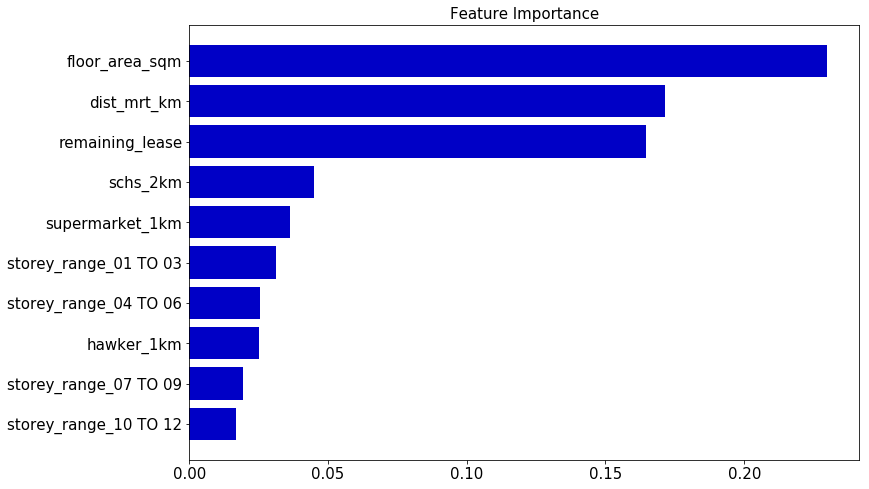

In [57]:
#Plot the 10 most impactful features
plt.figure(figsize=(12,8))
plt.barh(y=tuned_xgb_top10.sort_values('Importance',ascending=True)['Features'],width=tuned_xgb_top10.sort_values('Importance',ascending=True)['Importance'],color='#0000c6')

plt.title("Feature Importance", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [54]:
#Get more statistics of the predictions
print('max error:', max(y_test-xgr_tune_predictions))
print('max % error: {:.2f}'.format(max(abs(y_test-xgr_tune_predictions)/y_test)*100))
print('avg % error: {:.2f}'.format((sum((abs(y_test-xgr_tune_predictions)/y_test))/len(y_test)*100)))

max error: 252014.5625
max % error: 107.90
avg % error: 6.25


In [55]:
#Save the Tuned XGB Model
import pickle
filename = 'amenities_XGB_model.pickle'
pickle.dump(tuned_xgb, open(filename, 'wb'))